In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets,transforms,utils
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorboardX import SummaryWriter
import hiddenlayer as h

## 数据集的准备

In [3]:
#导入训练集
train_data = datasets.FashionMNIST(
    root = "./dataset/",
    train = True,                               #只使用训练集数据
    transform = transforms.ToTensor(),
    download = False
)
#加载训练集
train_loader = torch.utils.data.DataLoader(
    dataset = train_data,
    batch_size = 64,
    shuffle = False,                            #每次迭代前不打乱数据
    num_workers = 2,                            #使用2个进程
)

#导入测试集
test_data = datasets.FashionMNIST(
    root = "./dataset/",
    train = False,                             #不使用训练集数据
    download = False
)

test_data_x = test_data.data.type(torch.FloatTensor) / 255.0
test_data_x = torch.unsqueeze(test_data_x,dim = 1)
test_data_y = test_data.targets

for i,(batch_data,batch_label) in enumerate(train_loader):
    print("图像的shape：",batch_data.shape)
    print("标签的shape：",batch_label.shape)
    break

图像的shape： torch.Size([64, 1, 28, 28])
标签的shape： torch.Size([64])


## 展示一个batch数据图像

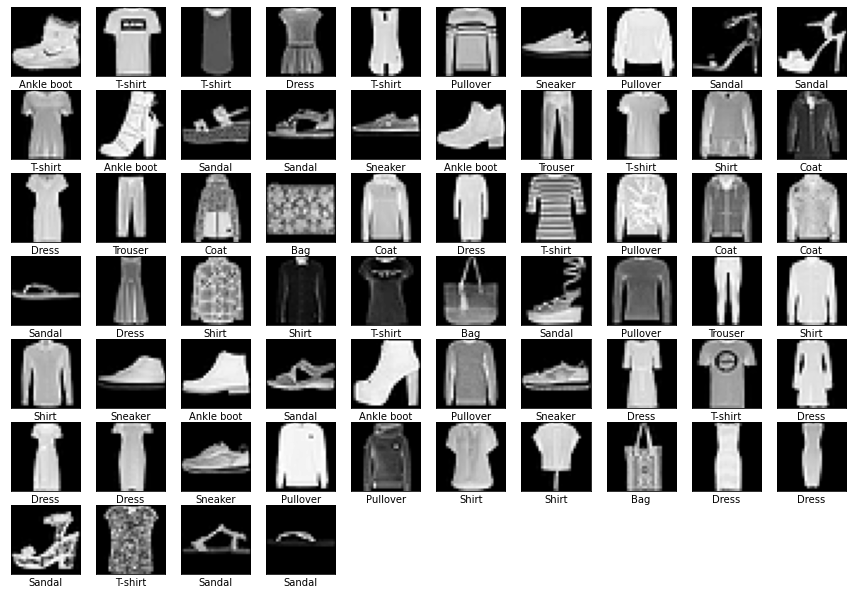

In [4]:
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
batch_x = batch_data.squeeze().numpy()                   #去掉值为1的维度，并转化成numpy数组
batch_y = batch_label.numpy()
plt.figure(figsize=(15,15))
for i in range(64):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(batch_x[i,:,:], cmap=plt.cm.gray)
    plt.xlabel(class_names[batch_y[i]])
plt.show()

### 为了测试效果，我们选用了3个不同的网络模型
* 4层全连接神经网络
* 4层CNN
* 7层CNN


### 我们将从以下三个角度评估三种模型的好坏之分，以及探究为什么会产生差距：
* 模型所占空间大小
* 训练相同伦次所用时长
* 测试集的预测准确率

# 全连接神经网络

### 定义4层全连接神经网络

In [9]:
from torch import nn, optim
import torch.nn.functional as F

class Fully_connected_nn(nn.Module):
    def __init__(self):
        super().__init__()
        #四个隐层
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        #一个输出层
        self.fc4 = nn.Linear(64, 10)
    
    #正向传播
    def forward(self, x):
        # 输出的tensor打平
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #softmax函数，上课学过
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

### 估计网络所占空间大小（这里使用torchsummary工具）

In [10]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_model = Fully_connected_nn().to(device)
summary(nn_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 128]          65,664
            Linear-3                   [-1, 64]           8,256
            Linear-4                   [-1, 10]             650
Total params: 476,490
Trainable params: 476,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.82
Estimated Total Size (MB): 1.83
----------------------------------------------------------------


**这里模型的总大小为1.83M**

### 定义训练方法

In [11]:
def NN_train(model,traindataloader,criterion,optimizer,epochs):
    history1 = h.History()
    canvas1 = h.Canvas()
    #criterion:损失函数
    #复制模型参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0                                                    #记录每次迭代总准确率的存储列表
    
    #开始迭代
    for epoch in range(epochs):                                       
        train_loss = 0.0                                              #本次迭代的总损失
        train_corrects = 0                                            #本次迭代预测正确次数
        train_num = 0                                                 #本次迭代训练的样本数量
        #逐个batch遍历所有图片，拿出数据和标签
        for step,(data,label) in enumerate(traindataloader):
            model.train()                                             #启用batch normalization和drop out。
            output = model(data)                                      #数据输入模型，获得输出
            pre_lab = torch.argmax(output,1)                          #返回输出最大的索引值，也就是预测的最大概率的标签
            loss = criterion(output,label)                            #计算损失
            optimizer.zero_grad()                                     #梯度置0
            loss.backward()                                           #反向传播
            optimizer.step()                                          #更新卷积核中参数
            train_loss += loss.item() * data.size(0)
            train_corrects += torch.sum(pre_lab == label.data)
            train_num += data.size(0)
           
        #计算一个epoch在训练集和验证集上的损失和精度
        L = train_loss / train_num      
        A = train_corrects.double().item() / train_num

        #即时可视化
        with canvas1:
            history1.log(epoch, loss=L, accuracy=A)
            canvas1.draw_plot([history1["loss"]])
            canvas1.draw_plot([history1["accuracy"]])
            time.sleep(0.1)
        history1.summary()
            
        #记录下模型最高精度下的模型权值，到最后将最优的参数赋给模型
        if A > best_acc:
            best_acc = A
            best_model_wts = copy.deepcopy(model.state_dict())
            
    #将训练过程中准确率最高的一组权值赋给网络模型
    model.load_state_dict(best_model_wts)
    return model

### 训练

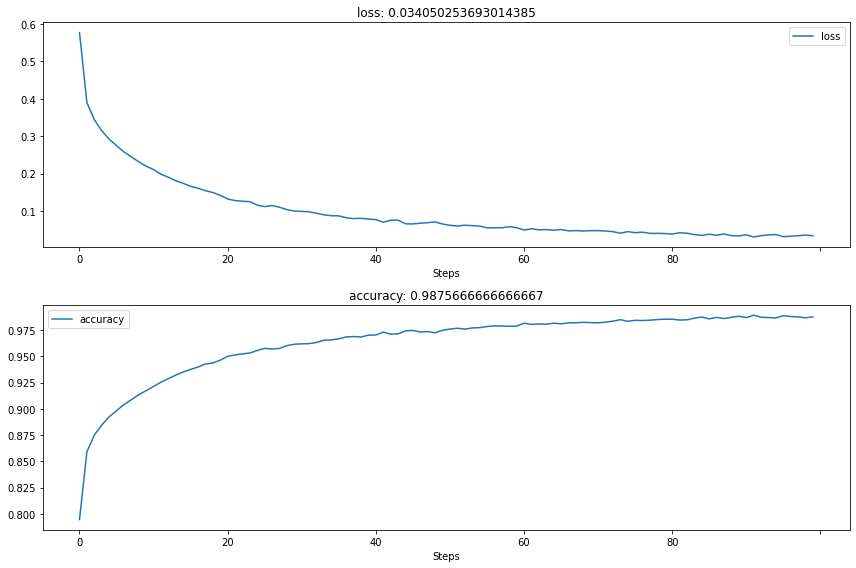

Last Step: 99
Training Time: 0:30:23.227660


In [114]:
NNdevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NN_model = Fully_connected_nn().to(device)
optimizer = torch.optim.Adam(NN_model.parameters(),lr = 0.0005)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
NN_model = NN_train(
    NN_model,train_loader,
    criterion,optimizer,epochs = 100
)

### 定义测试方法

In [14]:
def test(model,test_x,test_y):
    #对测试集进行预测，并可视化效果
    model.eval()
    output = model(test_x)
    pre_lab = torch.argmax(output,1)
    acc = accuracy_score(test_y,pre_lab)
    value = [acc,1-acc]
    label = ['True','False']
    color = ['orange','blue']
    explode =[0,0.05]
    plt.figure(figsize=(4,4))
    plt.pie(value,explode=explode,labels=label,autopct='%1.1f%%',colors = color)
    plt.title('ACC')
    plt.show()
    return pre_lab

### 输入测试集，查看预测精准度

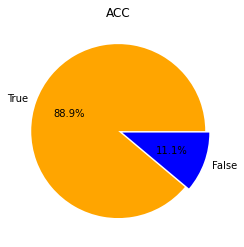

In [117]:
p = test(NN_model,test_data_x,test_data_y)

# 卷积神经网络

### 定义4层的CNN类

（1）5\*5卷积（步长为2）

（2）2\*2最大池化 

（3）全连接

（4）输出

In [14]:
#定义4层CNN
class CNN_Net_4L(nn.Module):
    def __init__(self):
        super().__init__()
        #卷积层（5*5卷积，ReLU，2*2最大池化）
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=6,
                kernel_size=5,
                stride = 2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = 2,
                stride = 2,
            )#池化后：（16*24*24）->（16*12*12）
        )
        #全连接层
        self.classifier = nn.Sequential(
                   nn.Linear(6*6*6,128),
                   nn.ReLU(),
                   nn.Linear(128,10),
                   nn.Softmax(),
        )
                  
            
                                     
    #前向传播
    def forward(self,x):
        x = self.conv_layer1(x)
        x = x.view(x.size(0),-1)
        output = self.classifier(x)
        return output

# print(CNN_Net_4L())

### 估计网络所占空间大小（这里使用torchsummary工具）

In [15]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_4L_model = CNN_Net_4L().to(device)
summary(CNN_4L_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 12, 12]             156
              ReLU-2            [-1, 6, 12, 12]               0
         MaxPool2d-3              [-1, 6, 6, 6]               0
            Linear-4                  [-1, 128]          27,776
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
           Softmax-7                   [-1, 10]               0
Total params: 29,222
Trainable params: 29,222
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.11
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


D:\Anaconda3\envs\yolov5test\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


**这里模型的总大小为0.13M，在网络层数相同的情况下，CNN占存储空间明显少于全连接网络**

### 训练方法

In [34]:
def CNN_4L_train(model,traindataloader,criterion,optimizer,epochs):
    history1 = h.History()
    canvas1 = h.Canvas()
    #criterion:损失函数
    #复制模型参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0                                                    #记录每次迭代总准确率的存储列表
    
    #开始迭代
    for epoch in range(epochs):                                       
        train_loss = 0.0                                              #本次迭代的总损失
        train_corrects = 0                                            #本次迭代预测正确次数
        train_num = 0                                                 #本次迭代训练的样本数量
        #逐个batch遍历所有图片，拿出数据和标签
        for step,(data,label) in enumerate(traindataloader):
            model.train()                                             #启用batch normalization和drop out。
            output = model(data)                                      #数据输入模型，获得输出
            pre_lab = torch.argmax(output,1)                          #返回输出最大的索引值，也就是预测的最大概率的标签
            loss = criterion(output,label)                            #计算损失
            optimizer.zero_grad()                                     #梯度置0
            loss.backward()                                           #反向传播
            optimizer.step()                                          #更新卷积核中参数
            train_loss += loss.item() * data.size(0)
            train_corrects += torch.sum(pre_lab == label.data)
            train_num += data.size(0)
           
        #计算一个epoch在训练集和验证集上的损失和精度
        L = train_loss / train_num      
        A = train_corrects.double().item() / train_num

        #即时可视化
        with canvas1:
            history1.log(epoch, loss=L, accuracy=A)
            canvas1.draw_plot([history1["loss"]])
            canvas1.draw_plot([history1["accuracy"]])
            time.sleep(0.1)
        history1.summary()
            
        #记录下模型最高精度下的模型权值，到最后将最优的参数赋给模型
        if A > best_acc:
            best_acc = A
            best_model_wts = copy.deepcopy(model.state_dict())
            
    #将训练过程中准确率最高的一组权值赋给网络模型
    model.load_state_dict(best_model_wts)
    return model

### 训练

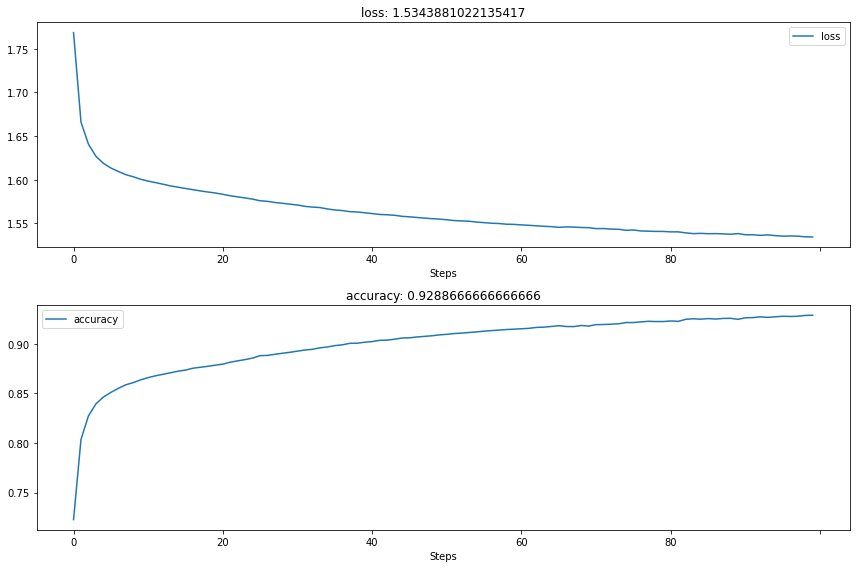

Last Step: 99
Training Time: 0:14:47.932950


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_4L_model = CNN_Net_4L().to(device)
optimizer = torch.optim.Adam(CNN_4L_model.parameters(),lr = 0.0005)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_4L_model = CNN_4L_train(
    CNN_4L_model,train_loader,
    criterion,optimizer,epochs = 100
)


### 在测试集上测试

D:\Anaconda3\envs\yolov5test\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


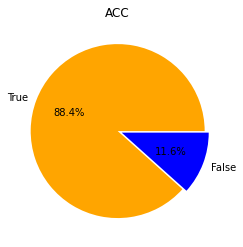

In [36]:
pre_lab1 = test(CNN_4L_model,test_data_x,test_data_y)

### 定义7层的CNN类

（1）3\*3卷积

（2）2\*2最大池化 

（3）3\*3卷积

（4）2\*2最大池化

（5）全连接

（6）全连接

（7）输出

In [8]:
#定义7层CNN
class CNN_Net_7L(nn.Module):
    def __init__(self):
        super().__init__()
        #第一层卷积层（3*3卷积，ReLU，2*2最大池化）
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = 2,
                stride = 2,
            )#池化后：（16*28*28）->（16*14*14）
        )
        #第二层卷积层（3*3卷积，ReLU，2*2最大池化）
        self.conv_layer2 = nn.Sequential(
                   nn.Conv2d(16,32,3,1,0),#14*14变12*12
                   nn.ReLU(),
                   nn.MaxPool2d(2,2),
        )
        #全连接层（3层）
        self.classifier = nn.Sequential(
                   nn.Linear(32 * 6 * 6,256),
                   nn.ReLU(),
                   nn.Linear(256,128),
                   nn.ReLU(),
                   nn.Linear(128,10),
                   nn.Softmax(),
        )
                  
                                     
    #前向传播
    def forward(self,x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = x.view(x.size(0),-1)
        output = self.classifier(x)
        return output
print(CNN_Net_7L())

CNN_Net_7L(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Softmax(dim=None)
  )
)


### 可视化网络模型（这里使用hiddenlayer工具）

D:\Anaconda3\envs\yolov5test\lib\site-packages\torch\nn\modules\module.py:887: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = self._slow_forward(*input, **kwargs)


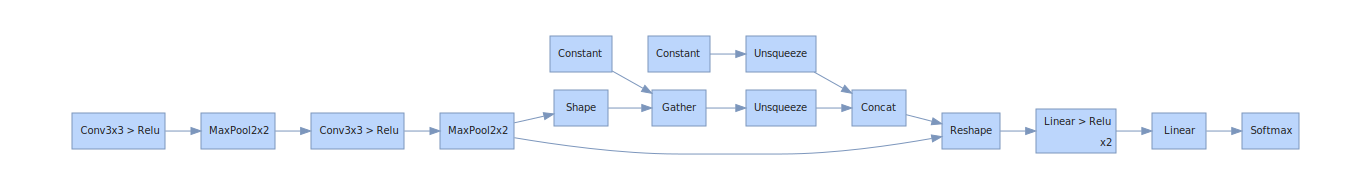

In [38]:
import hiddenlayer as hl
CNN_Net = CNN_Net_7L()
hl_graph = hl.build_graph(CNN_Net, torch.zeros([1,1, 28, 28]))
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

### 估计网络所占空间大小（这里使用torchsummary工具）

In [39]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model = CNN_Net_7L().to(device)
summary(CNN_7L_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 12, 12]           4,640
              ReLU-5           [-1, 32, 12, 12]               0
         MaxPool2d-6             [-1, 32, 6, 6]               0
            Linear-7                  [-1, 256]         295,168
              ReLU-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
          Softmax-12                   [-1, 10]               0
Total params: 334,154
Trainable params: 334,154
Non-trainable params: 0
-------------------------------

D:\Anaconda3\envs\yolov5test\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### 不加入验证集的训练结果

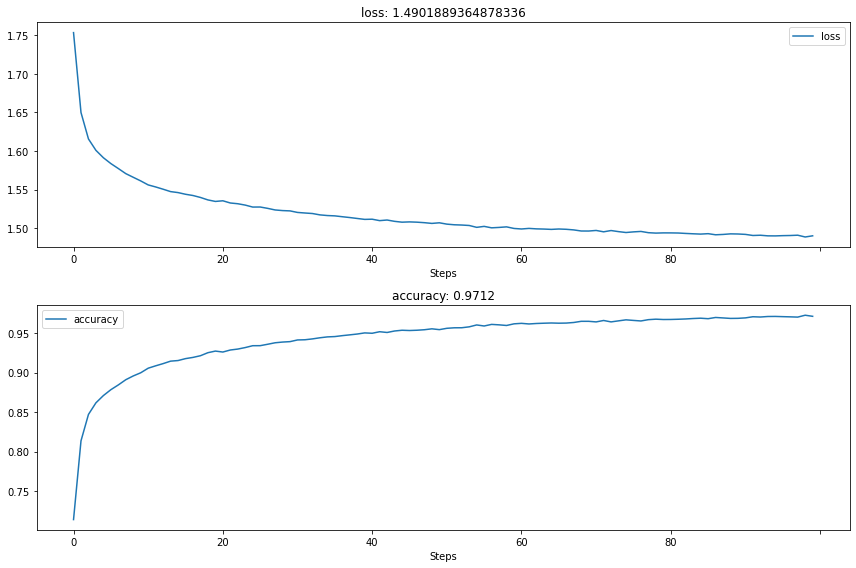

Last Step: 99
Training Time: 1:02:42.387475


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model_0 = CNN_Net_7L().to(device)
optimizer = torch.optim.Adam(CNN_7L_model_0.parameters(),lr = 0.0005)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model_0 = CNN_4L_train(
    CNN_7L_model_0,train_loader,
    criterion,optimizer,epochs = 100
)

### 测试

D:\Anaconda3\envs\yolov5test\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


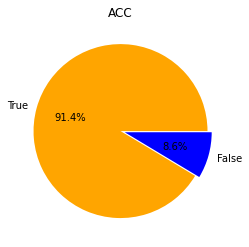

In [48]:
pre_lab2 = test(CNN_7L_model_0,test_data_x,test_data_y)

### 改善训练方法（加入验证集）

In [11]:
def CNN_7L_train(model,traindataloader,criterion,optimizer,epochs):
    history2 = h.History()
    history3 = h.History()
    canvas2 = h.Canvas()
    #criterion:损失函数
    train_rate = 0.75                                                     #训练数据里1/4做训练集，剩下的1/4做验证集
    #复制模型参数
    best_model_wts = copy.deepcopy(model.state_dict())   
    best_acc = 0.0                                                        #记录每次迭代总准确率的存储列表
    
    #开始迭代
    for epoch in range(epochs):                                       
        train_loss = 0.0                                                  #本次迭代的训练损失
        train_corrects = 0                                                #本次迭代训练集上的预测正确次数
        train_num = 0                                                     #本次迭代训练的样本数量
        val_loss = 0.0                                                    #本次迭代验证损失
        val_corrects = 0                                                  #本次迭代的验证正确次数
        val_num = 0                                                       #本次迭代验证样本数量
        #逐个batch遍历所有图片，拿出数据和标签
        for step,(data,label) in enumerate(traindataloader):
            if step < round(len(traindataloader) * train_rate):
                model.train()                                             #启用batch normalization和drop out。
                output = model(data)                                      #数据输入模型，获得输出
                pre_lab = torch.argmax(output,1)                          #返回输出最大的索引值，也就是预测的最大概率的标签
                loss = criterion(output,label)                            #计算损失
                optimizer.zero_grad()                                     #梯度置0
                loss.backward()                                           #反向传播
                optimizer.step()                                          #更新卷积核中参数
                train_loss += loss.item() * data.size(0)
                train_corrects += torch.sum(pre_lab == label.data)
                train_num += data.size(0)
            else:
                model.eval()                                              #验证时不启用 Batch Normalization 和 Dropout。
                output = model(data)                                       #数据输入模型，获得输出
                pre_lab = torch.argmax(output,1)                          #找到输出的1*10向量上最大值的索引
                loss = criterion(output,label)                              #计算损失
                val_loss += loss.item() * data.size(0)                     
                val_corrects += torch.sum(pre_lab == label.data)
                val_num += data.size(0)
           
        #计算一个epoch在训练集和验证集上的损失和精度
        t_L = train_loss / train_num      
        t_A = train_corrects.double().item() / train_num
        v_L = val_loss / val_num
        v_A = val_corrects.double().item() / val_num

        #即时可视化
        with canvas2:
            history2.log(epoch, loss=t_L, accuracy=t_A)
            history3.log(epoch, loss=v_L, accuracy=v_A)
            canvas2.draw_plot([history2["loss"],history3["loss"]],
                              labels = ["Train Loss","Validation Loss"])
            canvas2.draw_plot([history2["accuracy"],history3["accuracy"]],
                              labels = ["Train Accuracy","Validation Accuracy"])
            time.sleep(0.1)
        history2.summary()
            
        #记录下模型最高精度下的模型权值，到最后将最优的参数赋给模型
        if t_A > best_acc:
            best_acc = t_A
            best_model_wts = copy.deepcopy(model.state_dict())
            
    #将训练过程中准确率最高的一组权值赋给网络模型
    model.load_state_dict(best_model_wts)
    return model

### 训练结果

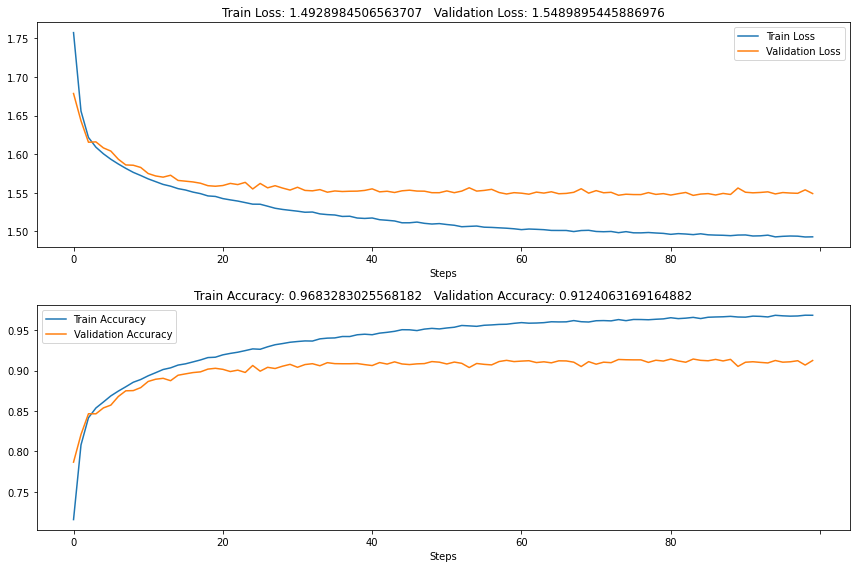

Last Step: 99
Training Time: 0:56:54.663065


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model = CNN_Net_7L().to(device)
optimizer = torch.optim.Adam(CNN_7L_model.parameters(),lr = 0.0005)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model = CNN_7L_train(
    CNN_7L_model,train_loader,
    criterion,optimizer,epochs = 100
)


### 在测试集上跑模型，输出测试结果

D:\Anaconda3\envs\yolov5test\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


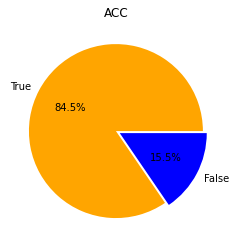

In [71]:
pre_lab3 = test(CNN_7L_model,test_data_x,test_data_y)

### 三种网络对比

* 存储空间：在网络层数相同的情况下，CNN模型所占存储空间明显小于全连接网络
* 训练时长：在同样训练50轮的情况下，..........
* 预测准确率：在同样50轮的情况下，........

**所以最终我们选择7层CNN作为本题的模型**


### 混淆矩阵

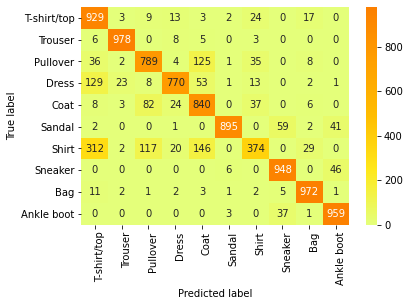

In [81]:
import seaborn as sns
#计算混淆矩阵并可视化
class_label = train_data.classes
conf_mat = confusion_matrix(test_data_y,pre_lab3)
df_cm = pd.DataFrame(conf_mat,index = class_label,columns = class_label)
heatmap = sns.heatmap(df_cm,annot = True,fmt = "d",cmap = "Wistia")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation = 0,ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation = 90,ha='left')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()                        

#### 这里发现一个问题：

由上面的混淆矩阵可以看出，大部分测试集中的图片都能够被正确分类

但是这里有一个问题：T-shirt和shirt数据中有大量分类混淆的情况。

于是就引申出一个问题，如果图片中的图像不是正直的，或者不在图片正中间，n那么分类结果一定很差

下面进行验证：

### 对测试集图片进行顺时针旋转45度，测试结果

D:\Anaconda3\envs\yolov5test\lib\site-packages\torchvision\transforms\transforms.py:1200: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


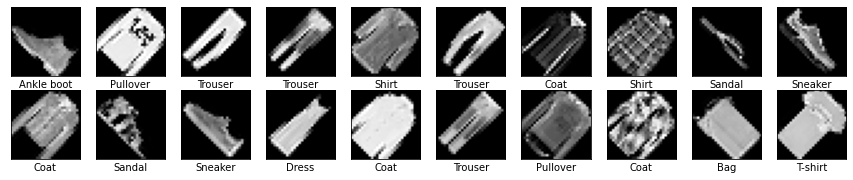

In [87]:
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #图片转换成tensor
        transforms.ToTensor(),
        #标准化，将数据映射到[0,1]
        transforms.Normalize(0, 1, inplace=False),
        #随机旋转
        transforms.RandomRotation((-45,-45), #顺时针旋转90度
                                  resample=False,
                                  expand=False,
                                  center=None,
                                  fill=None)
        ])
test_data = datasets.FashionMNIST(
    transform = transform,
    root = "./dataset/",
    train = False, #不使用训练集数据
    download = False
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_data,
    batch_size = 64,
    shuffle = False,                            #每次迭代前不打乱数据
)



test_data_x1 = test_data.data.type(torch.FloatTensor) / 255.0
test_data_x1 = torch.unsqueeze(test_data_x1,dim = 1)
test_data_y1 = test_data.targets


#获得一个batch数据
for i,(batch_data,batch_label) in enumerate(test_loader):
    break


    

# #可视化一个batch的图像
class_names = ['T-shirt', 'Trouser', 
               'Pullover', 'Dress', 
               'Coat','Sandal', 
               'Shirt', 'Sneaker', 
               'Bag', 'Ankle boot']

#去掉值为1的维度，并转化成numpy数组
batch_x = batch_data.squeeze().numpy()
batch_y = batch_label.numpy()
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(batch_x[i,:,:], cmap=plt.cm.gray)
    plt.xlabel(class_names[batch_y[i]])
plt.show()

D:\Anaconda3\envs\yolov5test\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


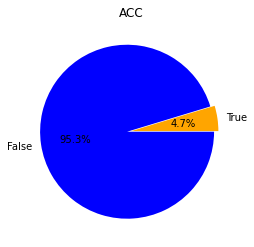

In [88]:
p = test(CNN_7L_model,batch_data,batch_label)

可以看到只有4.7%的精度，少得可怜

### 对图像标准化和增强

这里对图像分别进行了：

1.标准化

2.放大到35\*35再随机裁剪到28\*28

3.随机在-180到180度之间旋转

4.20%概率水平翻转

5.20%概率垂直翻转

In [5]:
# transforms函数可以对下载的数据做一些预处理
# Compose 指的是将多个transforms操作组合在一起
# ToTensor 是将[0,255] 范围 转换为[0,1]
# 灰度图片（channel=1），所以每一个括号内只有一个值，前者代表mean，后者std（标准差）
# 彩色图片（channel=3），所以每一个括号内有三个值，如
# transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
transform2 = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #图片转换成tensor
        transforms.ToTensor(),
        #标准化，将数据映射到[0,1]
        transforms.Normalize(0, 1, inplace=False),
        #尺寸缩放后随机裁剪（放大到35*35再随机裁剪28*28）
        transforms.Resize(35,interpolation=2),
        transforms.RandomCrop(28, padding=None, 
                              pad_if_needed=False,
                              fill=0,
                              padding_mode='constant'),
        #随机旋转
        transforms.RandomRotation(180, #从180到-180度之间随机旋转
                                  resample=False,
                                  expand=False,
                                  center=None,
                                  fill=None),
        #水平翻转
        transforms.RandomHorizontalFlip(p=0.2),
        #垂直翻转
        transforms.RandomVerticalFlip(p=0.2),
        ])

#准备训练数据集
train_data2 = datasets.FashionMNIST(
    root = "./dataset/",
    train = True,#只使用训练集数据
    transform = transform2,
    download = False
)

#定义一个数据加载器
train_loader2 = torch.utils.data.DataLoader(
    dataset = train_data2,
    batch_size = 64,
    shuffle = True,#每次迭代前不打乱数据
    num_workers = 2,#使用2个进程
)


D:\Anaconda3\envs\yolov5test\lib\site-packages\torchvision\transforms\transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
D:\Anaconda3\envs\yolov5test\lib\site-packages\torchvision\transforms\transforms.py:1200: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


### 展示增强后的数据集图像

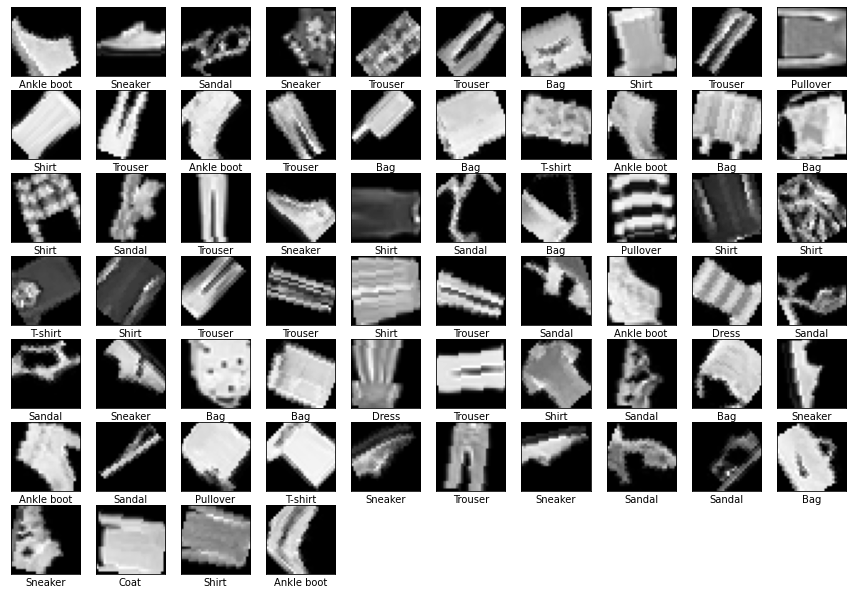

In [16]:
#获得一个batch数据
for i,(batch_data,batch_label) in enumerate(train_loader2):
    break


# #可视化一个batch的图像
class_names = ['T-shirt', 'Trouser', 
               'Pullover', 'Dress', 
               'Coat','Sandal', 
               'Shirt', 'Sneaker', 
               'Bag', 'Ankle boot']

#去掉值为1的维度，并转化成numpy数组
batch_x = batch_data.squeeze().numpy()
batch_y = batch_label.numpy()
plt.figure(figsize=(15,15))
for i in range(64):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(batch_x[i,:,:], cmap=plt.cm.gray)
    plt.xlabel(class_names[batch_y[i]])
plt.show()

## 下面通过测试寻找最合适的如下三个参数（20个epoch）：
* learning-rate

* batch-size

* poolsize


### 学习率测试

这里我们限制batch-size = 64,epoch = 20,polling_size = 2

learning_rate = 0.1

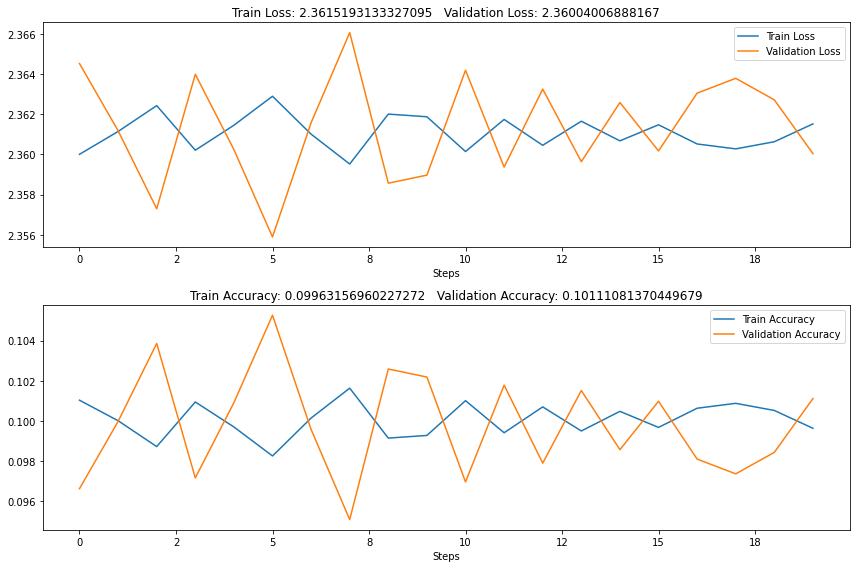

Last Step: 19
Training Time: 0:14:45.545759


In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model_lr1 = CNN_Net_7L().to(device)
optimizer = torch.optim.Adam(CNN_7L_model_lr1.parameters(),lr = 0.1)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model_lr1 = CNN_7L_train(
    CNN_7L_model_lr1,train_loader2,
    criterion,optimizer,epochs = 20
)

learning_rate = 0.01

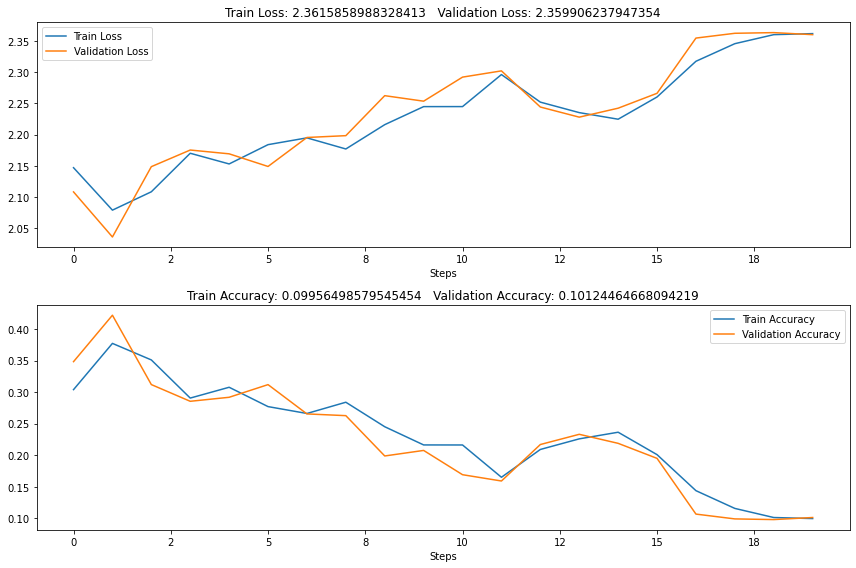

Last Step: 19
Training Time: 0:13:44.469504


In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model_lr2 = CNN_Net_7L().to(device)
optimizer = torch.optim.Adam(CNN_7L_model_lr2.parameters(),lr = 0.01)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model_lr2 = CNN_7L_train(
    CNN_7L_model_lr2,train_loader2,
    criterion,optimizer,epochs = 20
)

learning_rate = 0.001

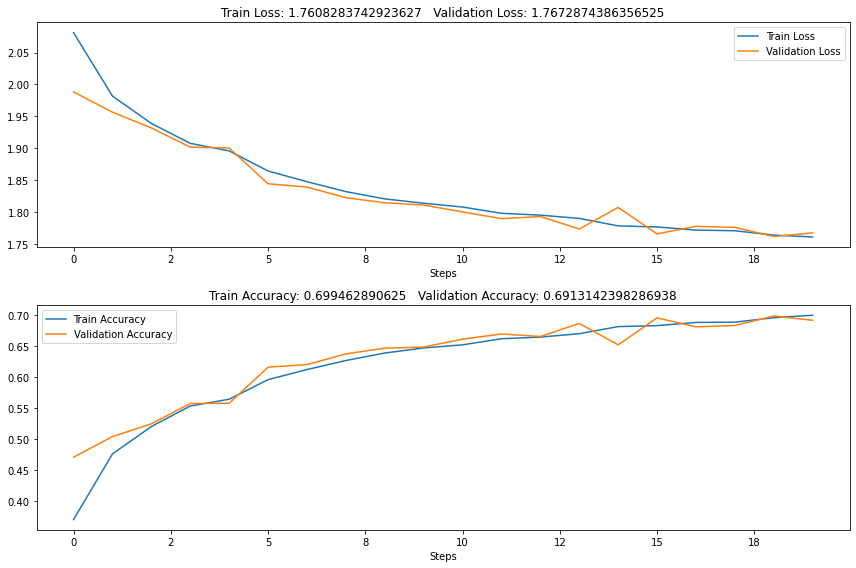

Last Step: 19
Training Time: 0:13:53.404259


In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model_lr3 = CNN_Net_7L().to(device)
optimizer = torch.optim.Adam(CNN_7L_model_lr3.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model_lr3 = CNN_7L_train(
    CNN_7L_model_lr3,train_loader2,
    criterion,optimizer,epochs = 20
)

learning_rate = 0.0005

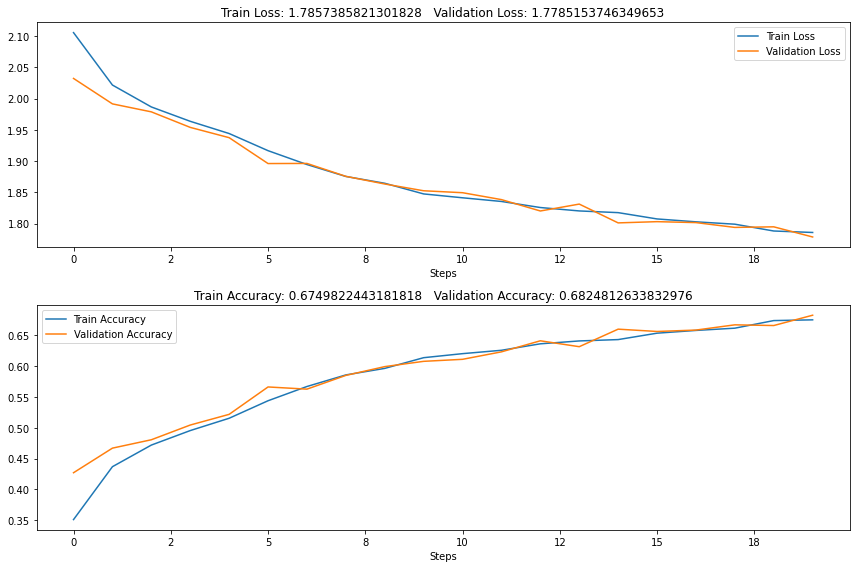

Last Step: 19
Training Time: 0:13:41.477825


In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model_lr4 = CNN_Net_7L().to(device)
optimizer = torch.optim.Adam(CNN_7L_model_lr4.parameters(),lr = 0.0005)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model_lr4 = CNN_7L_train(
    CNN_7L_model_lr4,train_loader2,
    criterion,optimizer,epochs = 20
)

### 根据结果，画出如下分组条形图
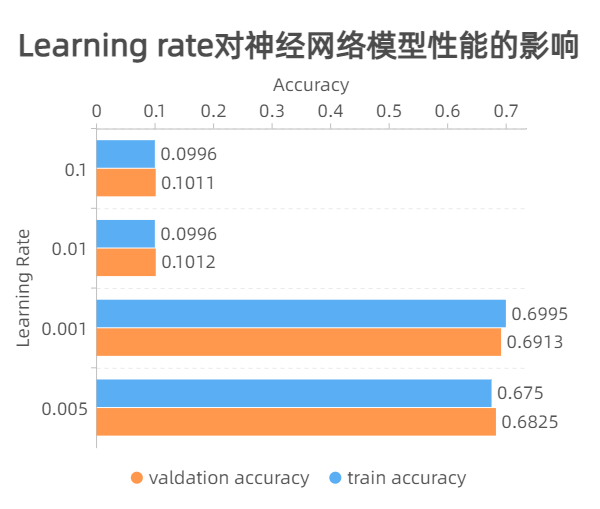

得出结论，learning rate = 0.001效果最佳

### batch-size测试

这里我们限制lr = 0.001,epoch = 10,polling_size = 2

由于本身设定batch-size = 64，于是这里我们就不跑代码了，直接记录数据

val_acc = 0.6913,train_acc = 0.6995 

batch-size = 128

In [100]:
train_loader3 = torch.utils.data.DataLoader(
    dataset = train_data2,
    batch_size = 128,
    shuffle = True,#每次迭代前不打乱数据
    num_workers = 2,#使用2个进程
)

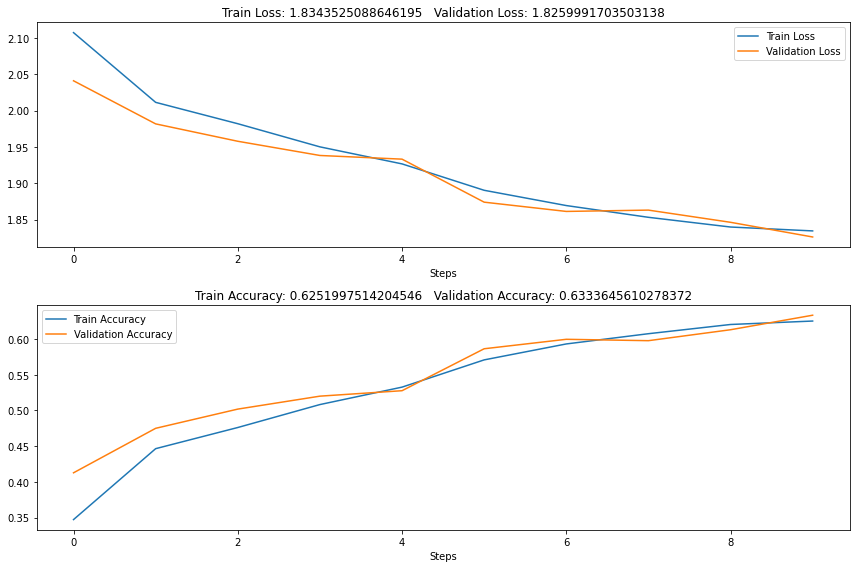

Last Step: 9
Training Time: 0:06:36.443046


In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model_bs1 = CNN_Net_7L().to(device)
optimizer = torch.optim.Adam(CNN_7L_model_bs1.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model_bs1 = CNN_7L_train(
    CNN_7L_model_bs1,train_loader3,
    criterion,optimizer,epochs = 10
)

batch-size = 256

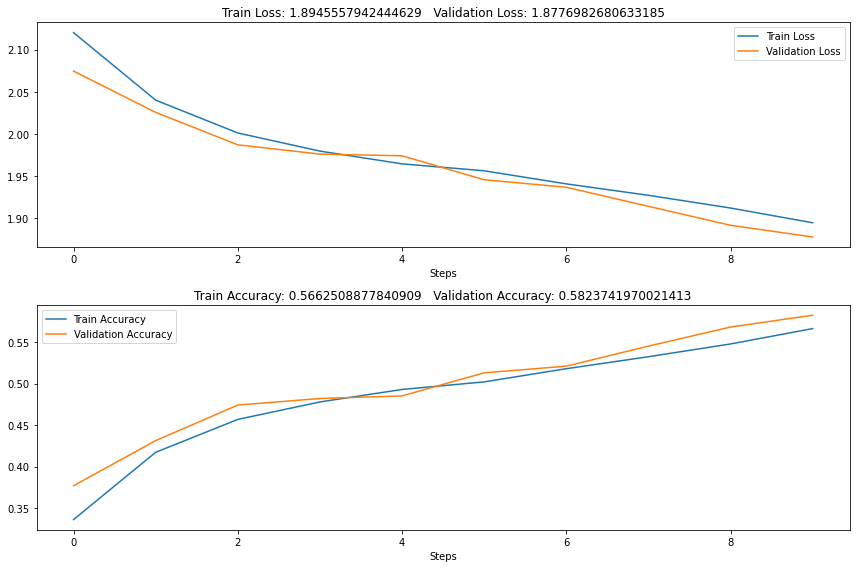

Last Step: 9
Training Time: 0:06:53.271163


In [103]:
train_loader4 = torch.utils.data.DataLoader(
    dataset = train_data2,
    batch_size = 256,
    shuffle = True,#每次迭代前不打乱数据
    num_workers = 2,#使用2个进程
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model_bs2 = CNN_Net_7L().to(device)
optimizer = torch.optim.Adam(CNN_7L_model_bs2.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model_bs2 = CNN_7L_train(
    CNN_7L_model_bs2,train_loader4,
    criterion,optimizer,epochs = 10
)

batch-size = 512

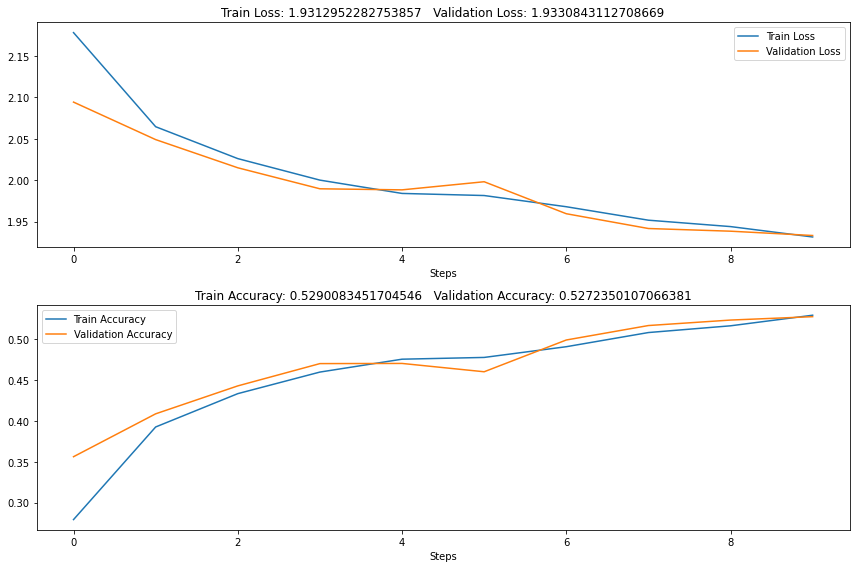

Last Step: 9
Training Time: 0:06:04.189059


In [107]:
train_loader4_2 = torch.utils.data.DataLoader(
    dataset = train_data2,
    batch_size = 512,
    shuffle = True,#每次迭代前不打乱数据
    num_workers = 2,#使用2个进程
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model_bs2 = CNN_Net_7L().to(device)
optimizer = torch.optim.Adam(CNN_7L_model_bs2.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model_bs2 = CNN_7L_train(
    CNN_7L_model_bs2,train_loader4_2,
    criterion,optimizer,epochs = 10
)

batch-size = 1024

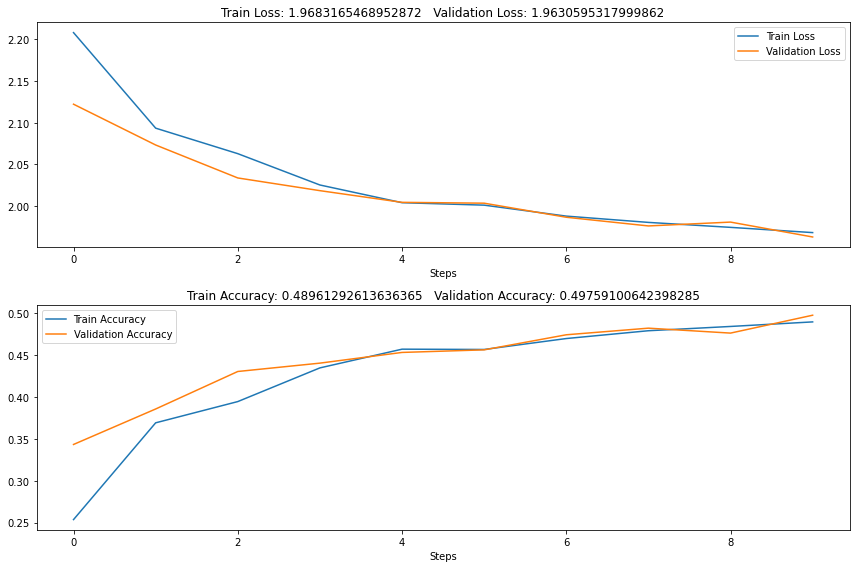

Last Step: 9
Training Time: 0:06:13.959479


In [104]:
train_loader5 = torch.utils.data.DataLoader(
    dataset = train_data2,
    batch_size = 1024,
    shuffle = True,#每次迭代前不打乱数据
    num_workers = 2,#使用2个进程
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model_bs3 = CNN_Net_7L().to(device)
optimizer = torch.optim.Adam(CNN_7L_model_bs3.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model_bs3 = CNN_7L_train(
    CNN_7L_model_bs3,train_loader5,
    criterion,optimizer,epochs = 10
)

batch-size = 2048

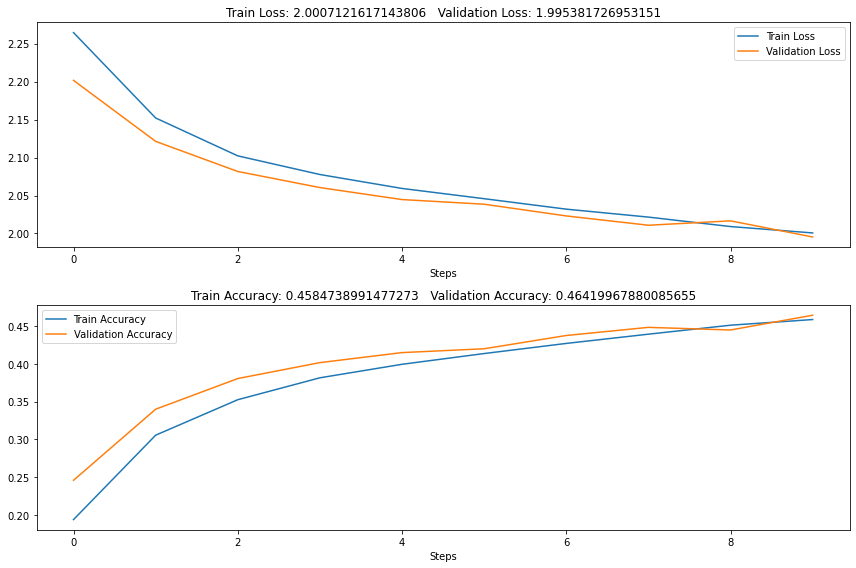

Last Step: 9
Training Time: 0:05:51.455490


In [105]:
train_loader6 = torch.utils.data.DataLoader(
    dataset = train_data2,
    batch_size = 2048,
    shuffle = True,#每次迭代前不打乱数据
    num_workers = 2,#使用2个进程
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model_bs4 = CNN_Net_7L().to(device)
optimizer = torch.optim.Adam(CNN_7L_model_bs4.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model_bs4 = CNN_7L_train(
    CNN_7L_model_bs4,train_loader6,
    criterion,optimizer,epochs = 10
)

batch-size = 4096

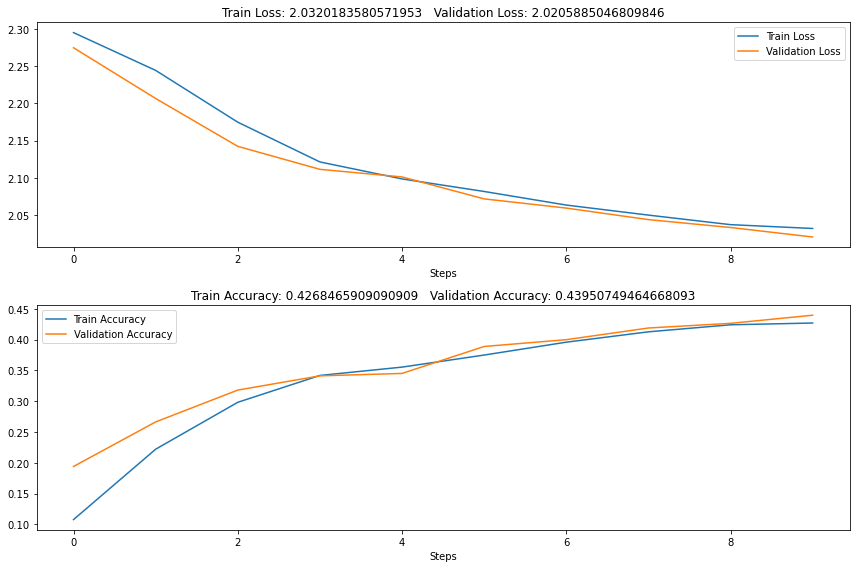

Last Step: 9
Training Time: 0:05:42.983513


In [106]:
train_loader7 = torch.utils.data.DataLoader(
    dataset = train_data2,
    batch_size = 4096,
    shuffle = True,#每次迭代前不打乱数据
    num_workers = 2,#使用2个进程
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model_bs5 = CNN_Net_7L().to(device)
optimizer = torch.optim.Adam(CNN_7L_model_bs5.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model_bs5 = CNN_7L_train(
    CNN_7L_model_bs5,train_loader7,
    criterion,optimizer,epochs = 10
)

### 根据以上数据画出分类柱形图
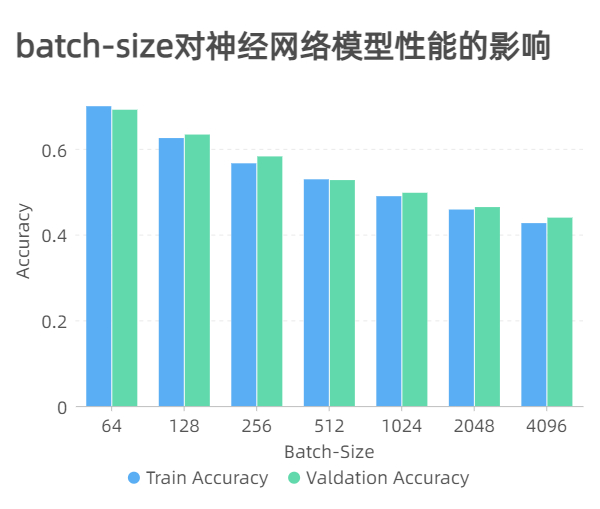
可以看出准确率随着batch-size的增大而减小，训练时长逐渐缩短，batch-size = 64效果最好

### pooling size

这里我们限制lr = 0.001,epoch = 20,batch-size = 64

由于本身设定pooling_size = 2，于是这里我们就不跑代码了，直接记录数据

val_acc = 0.6913,train_acc = 0.6995

这里我们只尝试pooling_size = 3

重新定义神经网络，更改pooling size 为3\*3

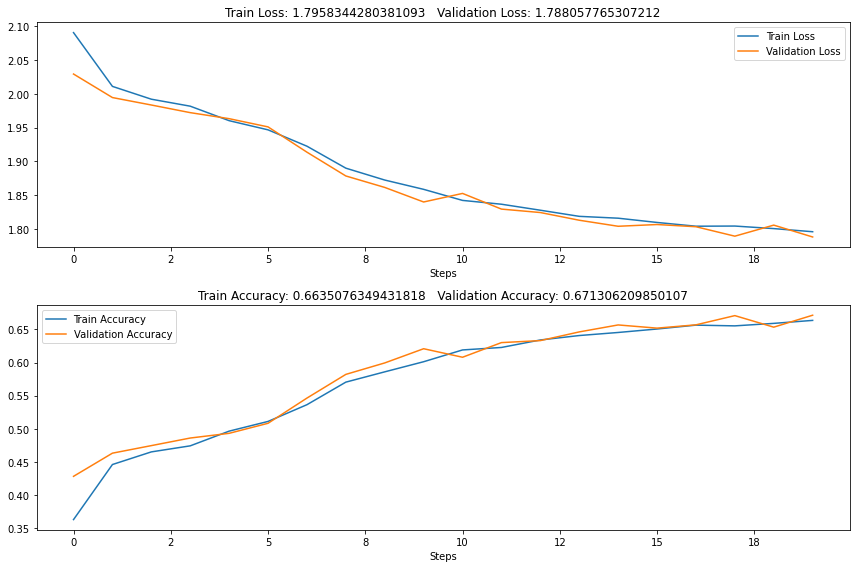

Last Step: 19
Training Time: 0:12:28.657570


In [113]:
#定义7层CNN
class CNN_Net_7L_1(nn.Module):
    def __init__(self):
        super().__init__()
        #第一层卷积层（3*3卷积，ReLU，2*2最大池化）
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = 3,
                stride = 3,
            )#池化后：（16*28*28）->（16*10*10）
        )
        #第二层卷积层（3*3卷积，ReLU，2*2最大池化）
        self.conv_layer2 = nn.Sequential(
                   nn.Conv2d(16,32,3,1,0),#10*10变8*8
                   nn.ReLU(),
                   nn.MaxPool2d(3,3),
        )
        #全连接层（3层）
        self.classifier = nn.Sequential(
                   nn.Linear(32 * 2 * 2,256),
                   nn.ReLU(),
                   nn.Linear(256,128),
                   nn.ReLU(),
                   nn.Linear(128,10),
                   nn.Softmax(),
        )                             
    #前向传播
    def forward(self,x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = x.view(x.size(0),-1)
        output = self.classifier(x)
        return output
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model_ps1 = CNN_Net_7L_1().to(device)
optimizer = torch.optim.Adam(CNN_7L_model_ps1.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model_ps1 = CNN_7L_train(
    CNN_7L_model_ps1,train_loader2,
    criterion,optimizer,epochs = 20
)

可以看到pooling size = 2效果更好

### 重新训练最终的模型500个epoch

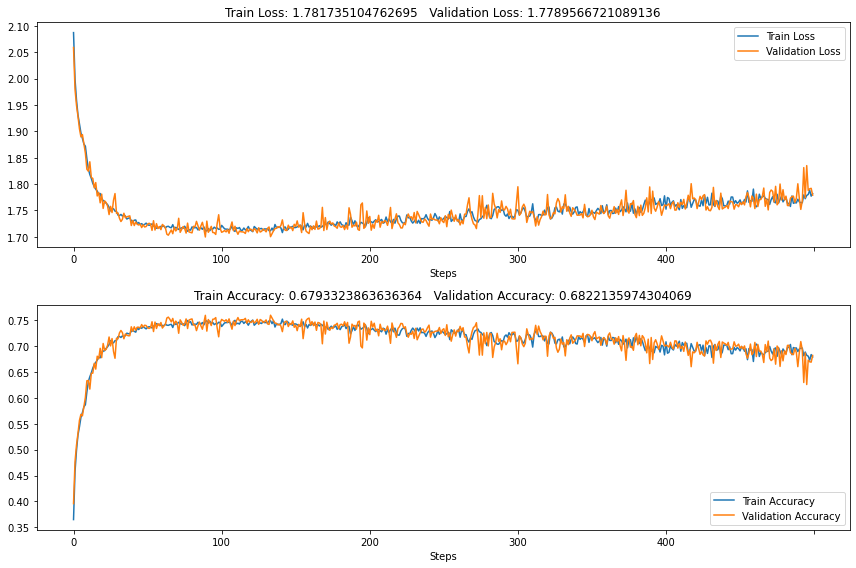

Last Step: 499
Training Time: 5:46:45.807381


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_7L_model_final = CNN_Net_7L().to(device)
optimizer = torch.optim.Adam(CNN_7L_model_final.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
CNN_7L_model_final = CNN_7L_train(
    CNN_7L_model_final,train_loader2,
    criterion,optimizer,epochs = 500
)

### 最终模型的测试结果

D:\Anaconda3\envs\yolov5test\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


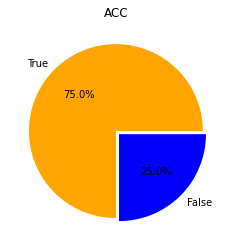

In [17]:
final_p = test(CNN_7L_model_final,batch_data,batch_label)

可以看到准确率明显上升